### 1.Detecting Rare Labels

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
train = pd.read_csv("filled_train.csv")
test = pd.read_csv("filled_test.csv")

In [37]:
train.head()

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0
4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,0.0


In [38]:
print(train.info())
print("***************************************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   holiday_type  object 
 6   locale        object 
 7   locale_name   object 
 8   description   object 
 9   transferred   object 
 10  city          object 
 11  state         object 
 12  store_type    object 
 13  cluster       int64  
 14  transactions  float64
dtypes: float64(2), int64(3), object(10)
memory usage: 349.5+ MB
None
***************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28512 non-null  int64  
 1   date          28512 non-null  object 
 2   store_nbr     28512 

In [39]:
cat_columns = [col for col in train.columns if pd.api.types.is_string_dtype(train[col]) and col!="date"]

In [40]:
num_columns = [col for col in train.columns if pd.api.types.is_numeric_dtype(train[col]) and col!="date"]

In [41]:
num_columns

['store_nbr', 'sales', 'onpromotion', 'cluster', 'transactions']

In [42]:
cat_columns

['family',
 'holiday_type',
 'locale',
 'locale_name',
 'description',
 'transferred',
 'city',
 'state',
 'store_type']

### 1.1Rare label detecting and encoding for categorical columns

In [43]:
#Let's see how many labels are there in each categorical feature-->>
for cat in cat_columns:
    print(f"{cat}:{train[cat].nunique()} distinct labels")

family:33 distinct labels
holiday_type:7 distinct labels
locale:4 distinct labels
locale_name:25 distinct labels
description:102 distinct labels
transferred:3 distinct labels
city:22 distinct labels
state:16 distinct labels
store_type:5 distinct labels


In [44]:
train.locale_name.value_counts()

missing                           2551824
Ecuador                            261954
Guayaquil                           19602
Riobamba                            17820
Guaranda                            16038
Latacunga                           16038
Quito                               14256
Ambato                              14256
Cuenca                              10692
Esmeraldas                           8910
Cayambe                              8910
Santo Domingo                        8910
El Carmen                            8910
Machala                              8910
Imbabura                             8910
Puyo                                 8910
Libertad                             8910
Cotopaxi                             8910
Manta                                8910
Ibarra                               7128
Quevedo                              7128
Santo Domingo de los Tsachilas       7128
Santa Elena                          7128
Loja                              

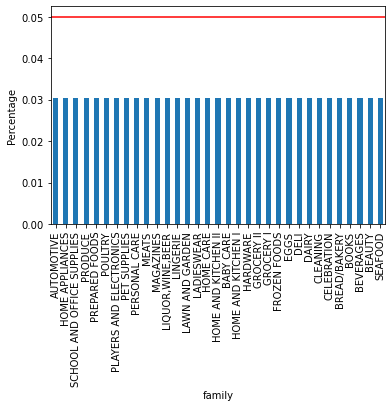

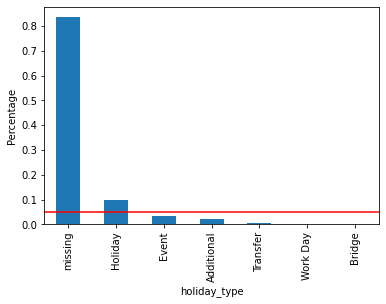

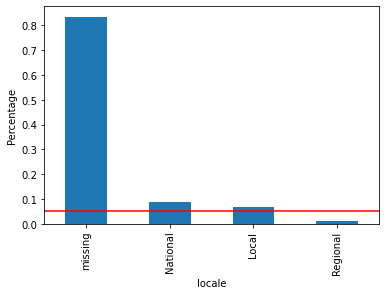

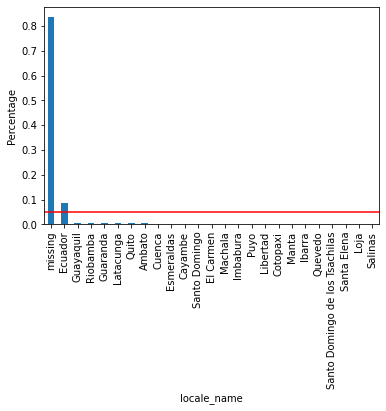

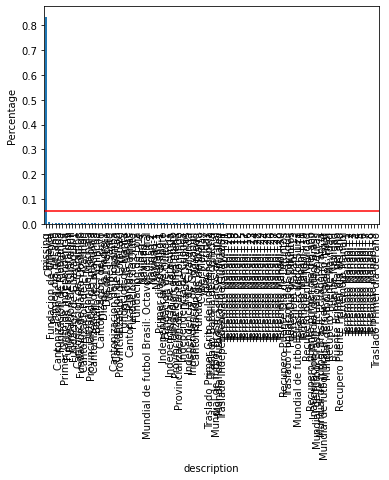

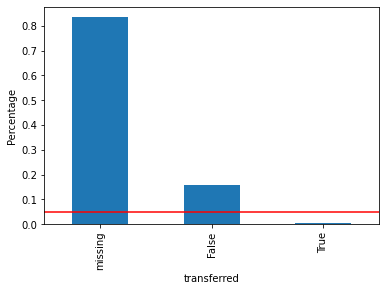

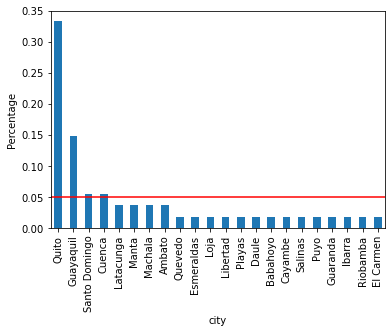

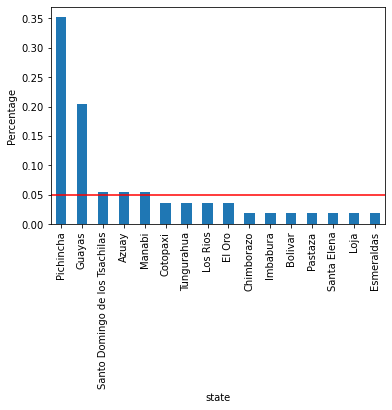

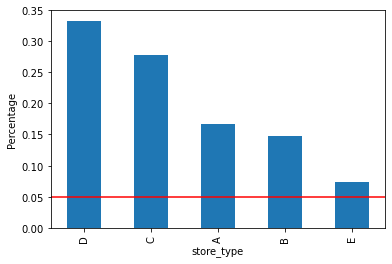

In [45]:
total_sales = len(train)

for column in cat_columns:
    temp = pd.Series(train[column].value_counts() / total_sales)
    
    fig = temp.plot.bar()
    fig.set_xlabel(column)
    fig.axhline(y=0.05, color="red")
    fig.set_ylabel("Percentage")
    plt.show()

In [46]:
def calculate_mean_target_per_category(df, var):
    total_sales = len(train)

    temp = pd.Series(df[var].value_counts() / total_sales).reset_index()
    temp.columns = [var, "percentage"]
    temp = temp.merge(df.groupby([var])["sales"].mean().reset_index(), on=var, how="left")
    
    return temp

In [47]:
def plot_categories(df, var):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=90)

    ax2 = ax.twinx()
    ax.bar(df.index, df["percentage"], color='lightgrey')
    ax2.plot(df.index, df["sales"], color='green', label='Seconds')
    ax.axhline(y=0.05, color='red')
    ax.set_ylabel('percentage of data per category')
    ax.set_xlabel(var)
    ax2.set_ylabel('sales average')
    plt.show()

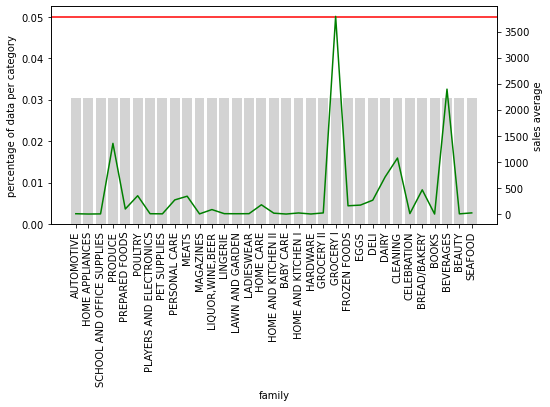

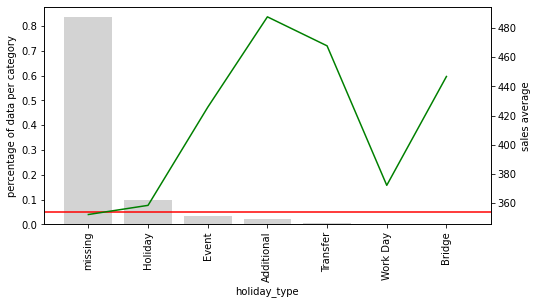

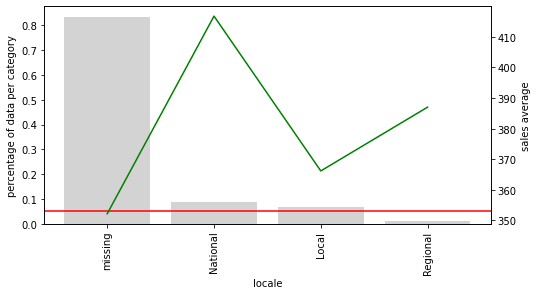

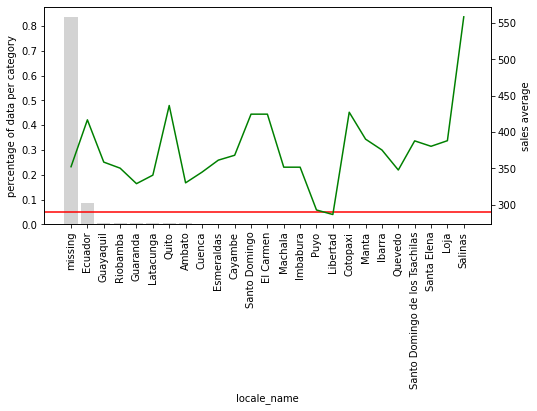

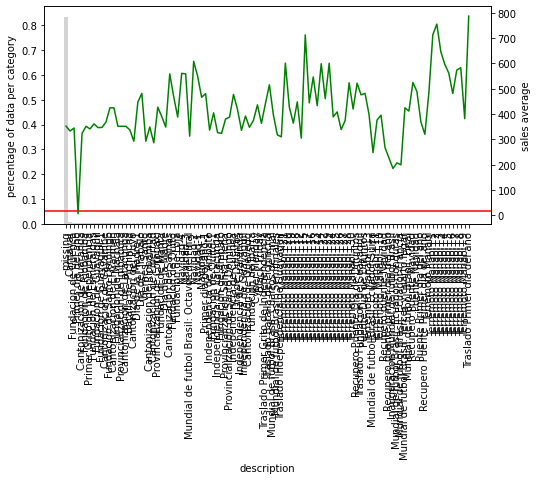

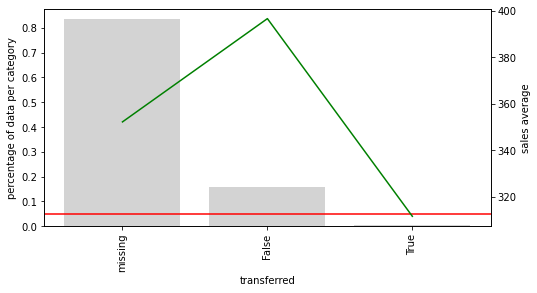

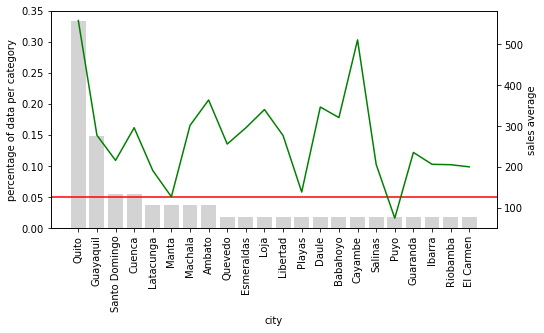

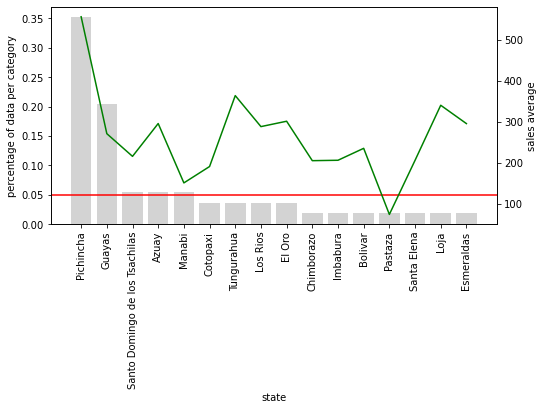

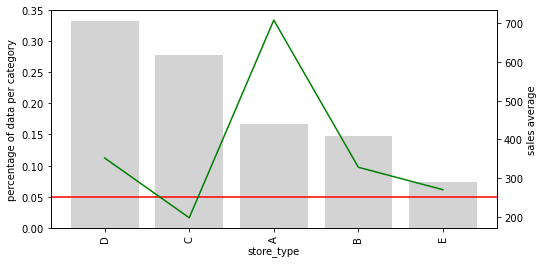

In [48]:
for cat in cat_columns:
    
    temp = calculate_mean_target_per_category(train, cat)
    plot_categories(temp, cat)

In [49]:
def group_rare_labels(df, var):
    total_sales = len(df)
    if df[var].nunique() >= 20:
        threshold = np.round(1 / df[var].nunique(), 2)
    else:
        threshold = 0.05
    temp = pd.Series(df[var].value_counts() / total_sales)
    grouping_dict = {
        k: ("rare" if k not in temp[temp >= threshold].index else k)
        for k in temp.index
    }
    df[var] = df[var].map(grouping_dict)
    return df

In [50]:
temp = train.copy()
for cat in cat_columns:
    temp = group_rare_labels(temp, cat)
temp

,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,rare,False,Quito,Pichincha,D,13,0.0
1,2013-01-01,1,BABY CARE,0.000,0,Holiday,National,Ecuador,rare,False,Quito,Pichincha,D,13,0.0
2,2013-01-01,1,BEAUTY,0.000,0,Holiday,National,Ecuador,rare,False,Quito,Pichincha,D,13,0.0
3,2013-01-01,1,BEVERAGES,0.000,0,Holiday,National,Ecuador,rare,False,Quito,Pichincha,D,13,0.0
4,2013-01-01,1,BOOKS,0.000,0,Holiday,National,Ecuador,rare,False,Quito,Pichincha,D,13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,Holiday,Local,rare,rare,False,Quito,Pichincha,B,6,2155.0
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,rare,rare,False,Quito,Pichincha,B,6,2155.0
3054345,2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,rare,rare,False,Quito,Pichincha,B,6,2155.0
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,Local,rare,rare,False,Quito,Pichincha,B,6,2155.0


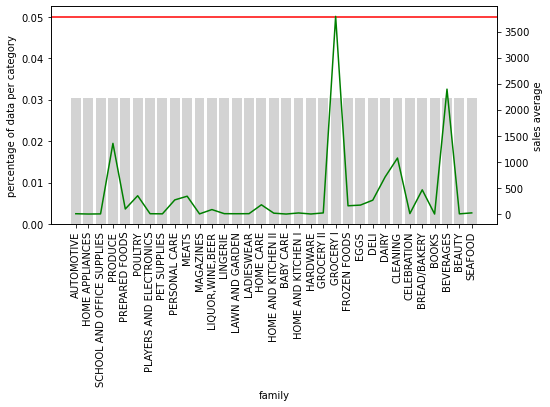

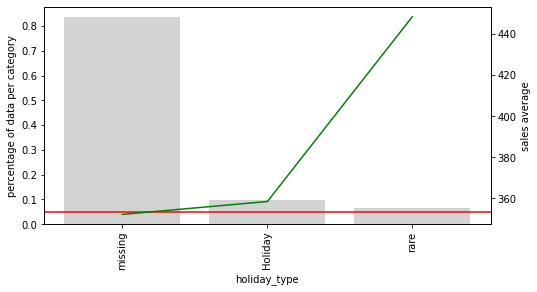

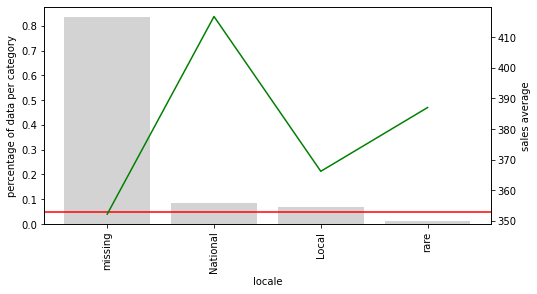

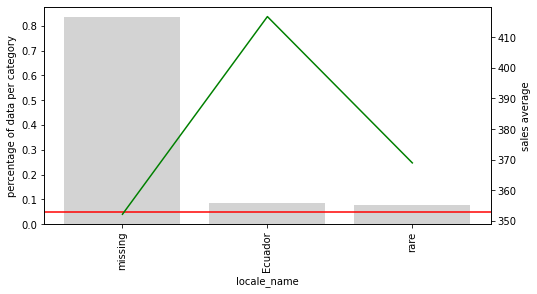

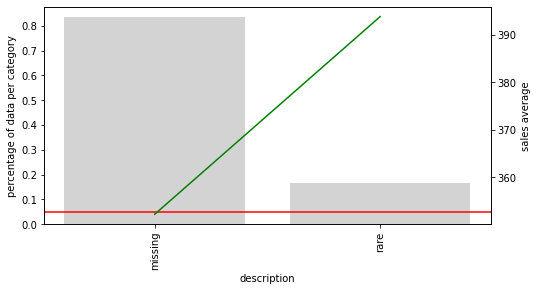

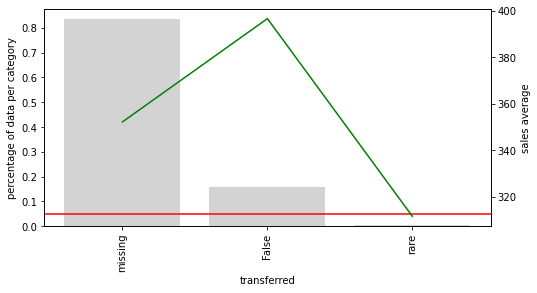

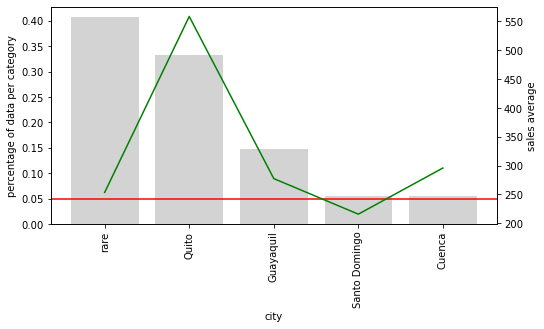

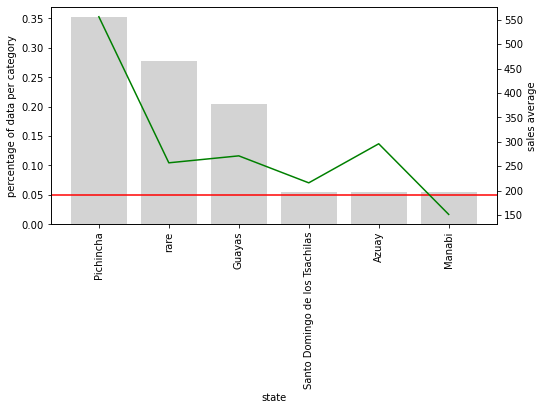

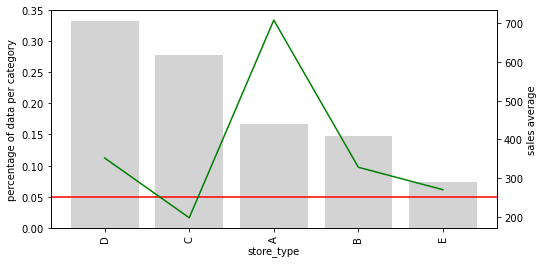

In [51]:
for cat in cat_columns:
    tmp = calculate_mean_target_per_category(temp, cat)
    plot_categories(tmp, cat)

In [52]:
temp.isna().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
city            0
state           0
store_type      0
cluster         0
transactions    0
dtype: int64

### 1.2 Rare label detecting and encoding for discrete numerical columns

In [19]:
for col in num_columns:
    print(f"{col}:{temp[col].nunique()} distinct labels")

store_nbr:54 distinct labels
sales:379610 distinct labels
onpromotion:362 distinct labels
cluster:17 distinct labels
transactions:4994 distinct labels


In [20]:
num_columns = [x for x in train.columns if pd.api.types.is_number(train[x][0])]

In [21]:
discrete_numerical_columns = [x for x in num_columns if train[x].nunique() < 100]
continuous_numerical_columns = [x for x in num_columns if train[x].nunique() > 100]

In [22]:
discrete_numerical_columns

['store_nbr', 'cluster']

In [23]:
continuous_numerical_columns

['sales', 'onpromotion', 'transactions']

In [55]:
train["cluster"].value_counts()# each store is important, hence no need to encode

3     395934
10    339372
6     339372
15    282810
13    226248
14    226248
11    169686
4     169686
8     169686
1     169686
9     113124
2     113124
7     113124
16     56562
5      56562
12     56562
17     56562
Name: cluster, dtype: int64

In [53]:
temp = group_rare_labels(temp, "cluster")

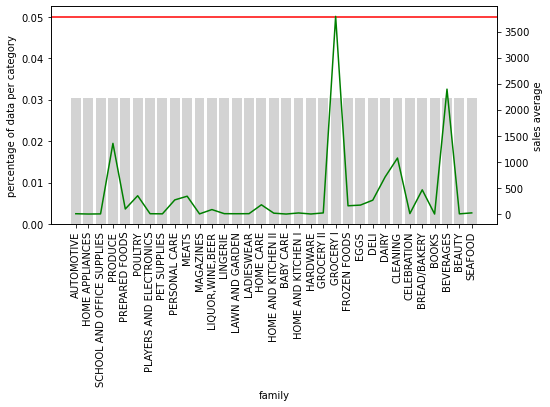

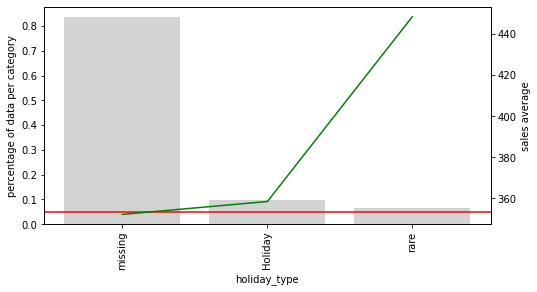

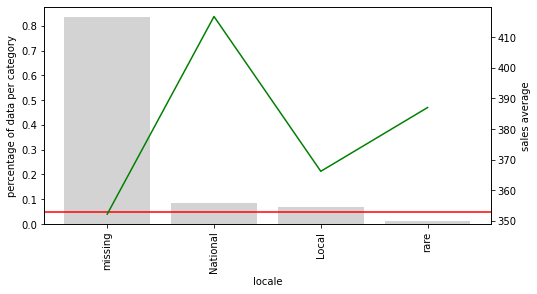

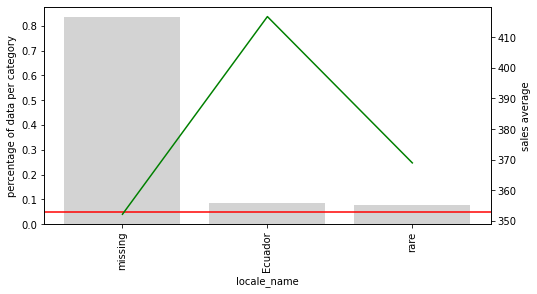

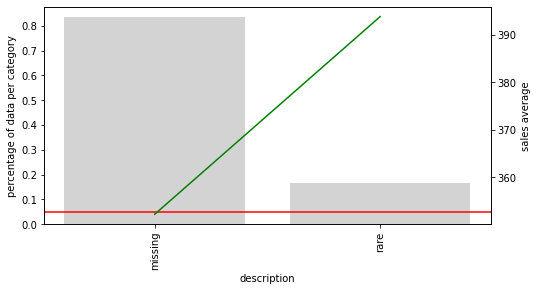

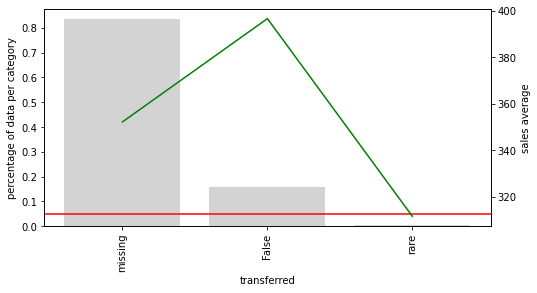

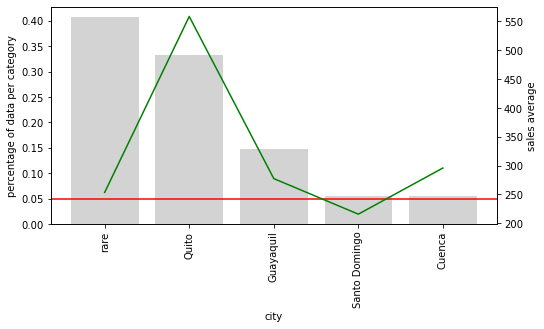

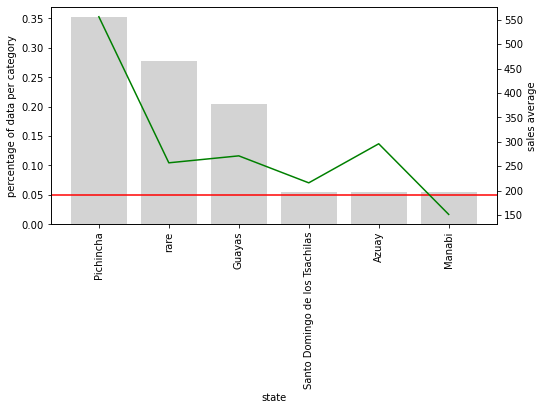

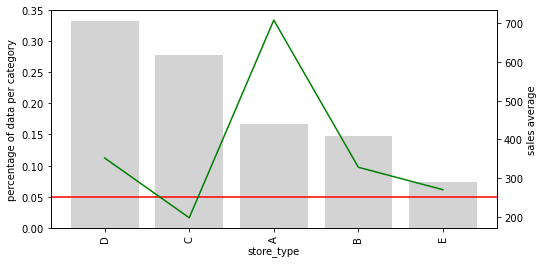

In [57]:
for cat in cat_columns:
    tmp = calculate_mean_target_per_category(temp, cat)
    plot_categories(tmp, cat)

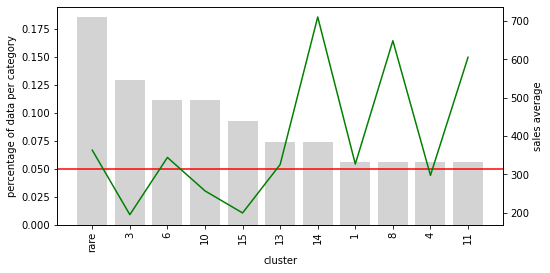

In [58]:
tmp = calculate_mean_target_per_category(temp, "cluster")
plot_categories(tmp, "cluster")

### 2.time to detect outliers
* checking in continuous numerical columns only

C:\Users\mertk\miniconda3\envs\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='transactions'>

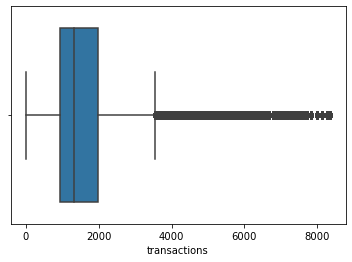

In [69]:
sns.boxplot(train.transactions)

In [60]:
for col in continuous_numerical_columns:
    train[col].boxplot

,sales,onpromotion,transactions
0,0.000,0,0.0
1,0.000,0,0.0
2,0.000,0,0.0
3,0.000,0,0.0
4,0.000,0,0.0
...,...,...,...
3054343,438.133,0,2155.0
3054344,154.553,1,2155.0
3054345,2419.729,148,2155.0
3054346,121.000,8,2155.0
